Imports and Setup

In [12]:
import os
import torch
import numpy as np
import cv2
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

%matplotlib inline

classes = ['bladder', 'kidney', 'liver', 'gallbladder', 'spleen', 'bowel']
img_size = 64


CNN Model

In [13]:
class ImprovedCNN(nn.Module):
    def __init__(self, num_classes):
        super(ImprovedCNN, self).__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2)
        )
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(64 * 8 * 8, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        return self.fc(x)


Dataset & Data Loading

In [14]:
class UltrasoundDataset(Dataset):
    def __init__(self, image_paths, labels, transform=None):
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img = cv2.imread(self.image_paths[idx], cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (img_size, img_size))
        img = self.transform(img) if self.transform else img
        return img, self.labels[idx]

def load_data(folder, class_list):
    paths, labels = [], []
    for fname in os.listdir(folder):
        if fname.endswith(".png"):
            for idx, cls in enumerate(class_list):
                if fname.startswith(cls):
                    paths.append(os.path.join(folder, fname))
                    labels.append(idx)
    return paths, labels


EDA

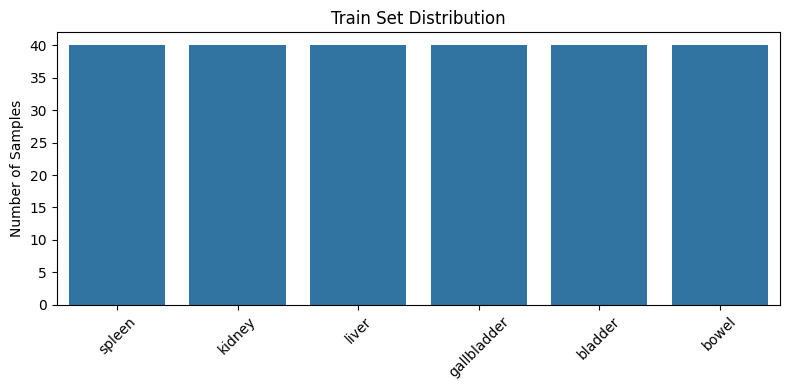

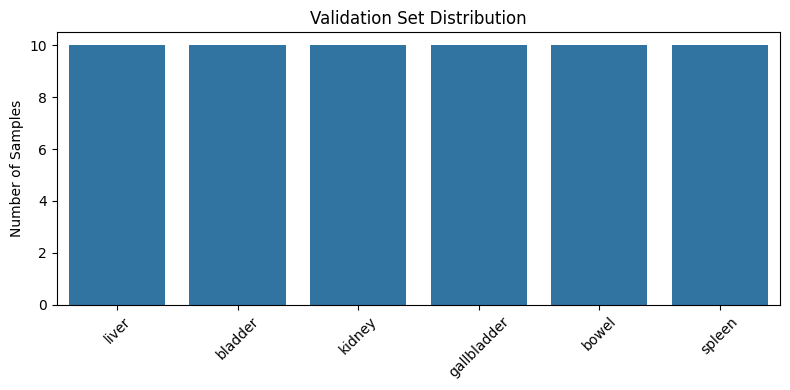

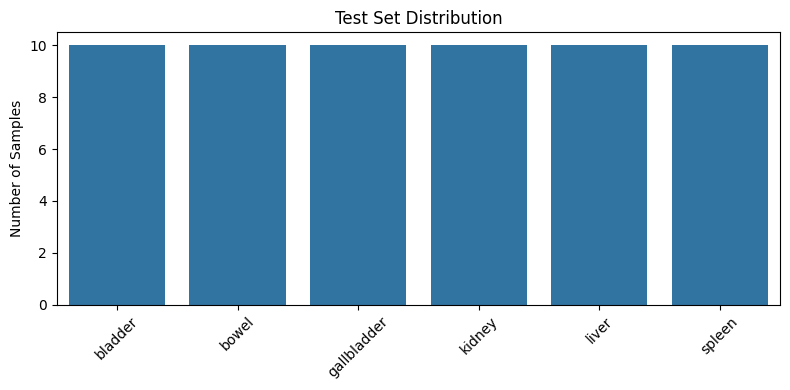

Showing sample ultrasound images from training set:


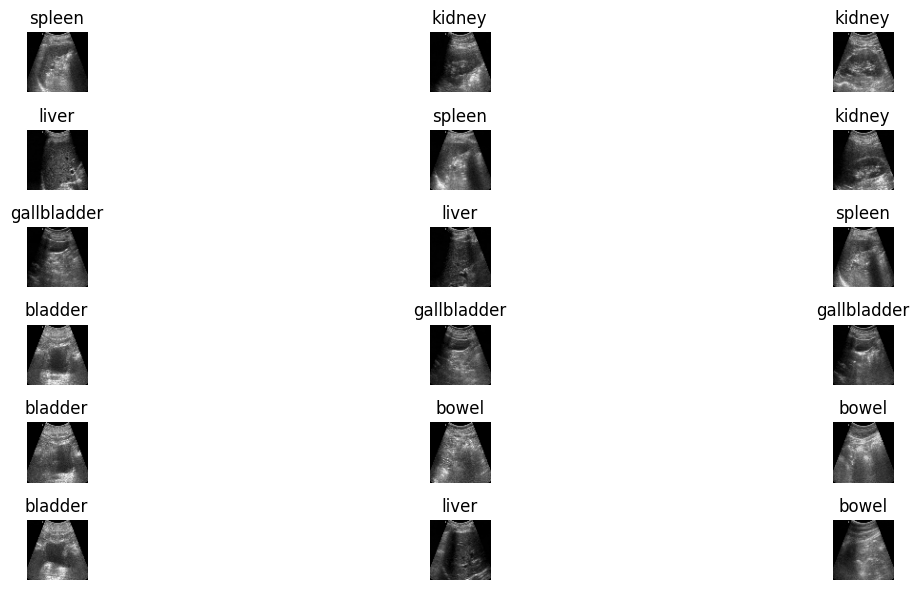

In [15]:
#!pip install seaborn
import matplotlib.pyplot as plt
from collections import Counter
from PIL import Image
import seaborn as sns



train_counts = Counter([classes[y] for y in y_train])
val_counts = Counter([classes[y] for y in y_val])
test_counts = Counter([classes[y] for y in y_test])

def plot_class_distribution(title, counter_dict):
    plt.figure(figsize=(8, 4))
    sns.barplot(x=list(counter_dict.keys()), y=list(counter_dict.values()))
    plt.title(title)
    plt.ylabel("Number of Samples")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

plot_class_distribution("Train Set Distribution", train_counts)
plot_class_distribution("Validation Set Distribution", val_counts)
plot_class_distribution("Test Set Distribution", test_counts)

# samples
def show_sample_images(image_paths, labels, class_names, samples_per_class=3):
    plt.figure(figsize=(15, 6))
    shown = {cls: 0 for cls in class_names}
    i = 0
    for path, label in zip(image_paths, labels):
        cls_name = class_names[label]
        if shown[cls_name] < samples_per_class:
            img = Image.open(path)
            plt.subplot(len(class_names), samples_per_class, i + 1)
            plt.imshow(img, cmap="gray")
            plt.title(cls_name)
            plt.axis("off")
            shown[cls_name] += 1
            i += 1
    plt.tight_layout()
    plt.show()

print("Showing sample ultrasound images from training set:")
show_sample_images(X_train, y_train, classes, samples_per_class=3)


Train, Evaluate & Report

In [16]:
def train(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0, 0, 0
    for x, y in loader:
        optimizer.zero_grad()
        outputs = model(x)
        loss = criterion(outputs, y)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        correct += (outputs.argmax(1) == y).sum().item()
        total += y.size(0)
    return total_loss / len(loader), correct / total

def evaluate(model, loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for x, y in loader:
            out = model(x)
            y_true.extend(y.numpy())
            y_pred.extend(out.argmax(1).numpy())
    return np.array(y_true), np.array(y_pred)

def report(title, y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n=== {title} ===")
    print(f"Accuracy : {acc:.4f}")
    print(f"Precision: {precision_score(y_true, y_pred, average='macro'):.4f}")
    print(f"Recall   : {recall_score(y_true, y_pred, average='macro'):.4f}")
    print(f"F1 Score : {f1_score(y_true, y_pred, average='macro'):.4f}")
    ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=classes).plot(cmap='Blues')
    plt.title(f"Confusion Matrix - {title}")
    plt.show()


In [17]:
transform = transforms.Compose([transforms.ToTensor()])

data_dir = "./datasets/img/train"
test_dir = "./datasets/img/test"

X_all, y_all = load_data(data_dir, classes)
X_test, y_test = load_data(test_dir, classes)
X_train, X_val, y_train, y_val = train_test_split(X_all, y_all, test_size=0.2, random_state=42, stratify=y_all)

train_ds = UltrasoundDataset(X_train, y_train, transform)
val_ds = UltrasoundDataset(X_val, y_val, transform)
test_ds = UltrasoundDataset(X_test, y_test, transform)

train_loader = DataLoader(train_ds, batch_size=16, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=16, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=16, shuffle=False)

model = ImprovedCNN(len(classes))
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

train_losses, val_losses, train_accs, val_accs = [], [], [], []


Training Loop

In [18]:
for epoch in range(15):
    tr_loss, tr_acc = train(model, train_loader, criterion, optimizer)
    val_y_true, val_y_pred = evaluate(model, val_loader)
    val_loss = criterion(model(torch.stack([val_ds[i][0] for i in range(len(val_ds))])), torch.tensor(y_val)).item()
    val_acc = accuracy_score(val_y_true, val_y_pred)

    train_losses.append(tr_loss)
    val_losses.append(val_loss)
    train_accs.append(tr_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}: Train Loss={tr_loss:.4f} Acc={tr_acc:.4f} | Val Loss={val_loss:.4f} Acc={val_acc:.4f}")


Epoch 1: Train Loss=0.6022 Acc=0.8000 | Val Loss=1.6534 Acc=0.4667
Epoch 2: Train Loss=0.0326 Acc=0.9917 | Val Loss=0.6589 Acc=0.8333
Epoch 3: Train Loss=0.0202 Acc=0.9958 | Val Loss=0.0874 Acc=0.9833
Epoch 4: Train Loss=0.0037 Acc=1.0000 | Val Loss=0.0779 Acc=0.9833
Epoch 5: Train Loss=0.0042 Acc=1.0000 | Val Loss=0.0519 Acc=0.9833
Epoch 6: Train Loss=0.0043 Acc=1.0000 | Val Loss=0.0311 Acc=0.9833
Epoch 7: Train Loss=0.0011 Acc=1.0000 | Val Loss=0.0326 Acc=0.9833
Epoch 8: Train Loss=0.0009 Acc=1.0000 | Val Loss=0.0358 Acc=0.9833
Epoch 9: Train Loss=0.0002 Acc=1.0000 | Val Loss=0.0308 Acc=0.9833
Epoch 10: Train Loss=0.0007 Acc=1.0000 | Val Loss=0.0264 Acc=0.9833
Epoch 11: Train Loss=0.0001 Acc=1.0000 | Val Loss=0.0267 Acc=0.9833
Epoch 12: Train Loss=0.0005 Acc=1.0000 | Val Loss=0.0269 Acc=0.9833
Epoch 13: Train Loss=0.0001 Acc=1.0000 | Val Loss=0.0307 Acc=0.9833
Epoch 14: Train Loss=0.0004 Acc=1.0000 | Val Loss=0.0429 Acc=0.9833
Epoch 15: Train Loss=0.0001 Acc=1.0000 | Val Loss=0.0451 

Evaluation und Learning Curves


=== Test Set ===
Accuracy : 1.0000
Precision: 1.0000
Recall   : 1.0000
F1 Score : 1.0000


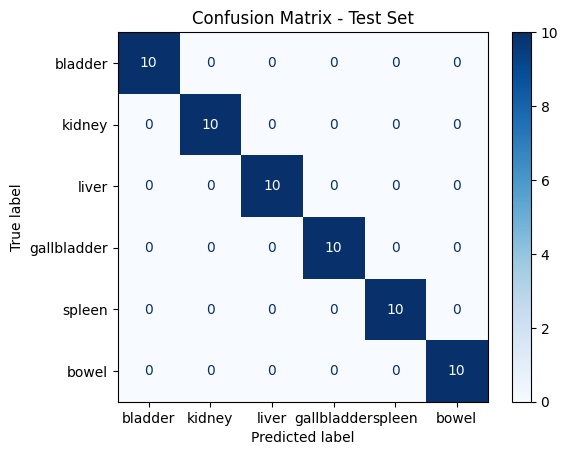

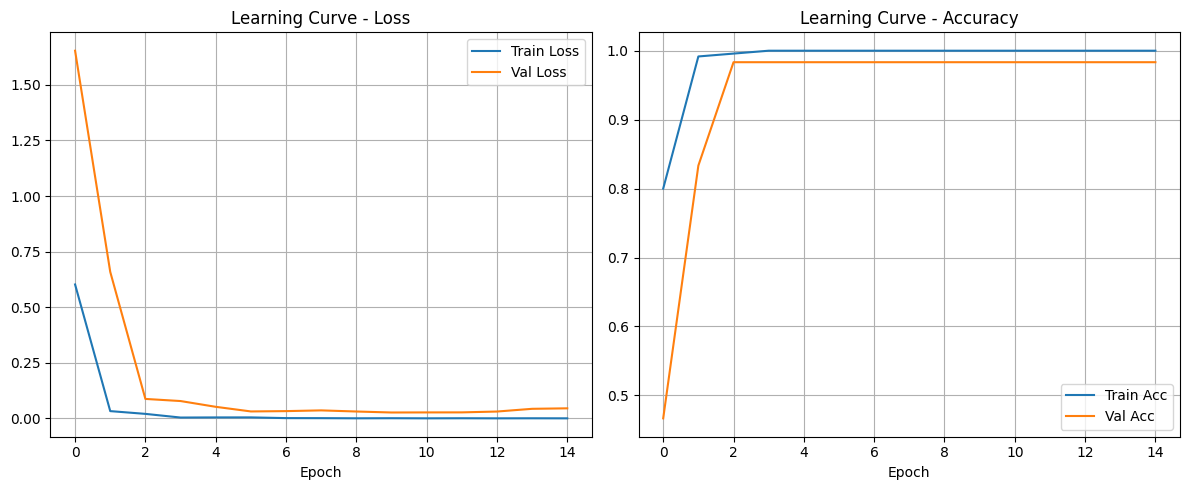

In [19]:
y_true, y_pred = evaluate(model, test_loader)
report("Test Set", y_true, y_pred)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Learning Curve - Loss")
plt.xlabel("Epoch")
plt.legend()
plt.grid()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.title("Learning Curve - Accuracy")
plt.xlabel("Epoch")
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()
